# Data Reduction

Data reduction is the process of calibrating astronomical images. Its goal is to go from an image in which pixel values are raw counts to an image in which each value is the number of photons in that pixel.

There are potentially several steps in data reduction. Which ones are actually applied depends on the instrument used to take the images.

[Fill in list after lecture]

## Recipes for reduction

There are two formulae we will typically use for reducing images. Which one you use depends on whether you need to scale the dark frames by exposure time.

### Case 1: Exposure time of dark *does* match science image

$$
L_{\text{calibrated}} = \frac{L_{\text{raw}} - D_{\text{NO sub bias}}}{F_{\text{calib}}}
$$

### Case 2: Exposure time of dark *does not* match science or flat images

In this case, a bias frame should be subtracted separately from correcting for dark current. The frames used for correcting the dark current also need to have bias subtracted so that they can be scaled by exposure time without also scaling the bias level. If $D_{\text{sub bias}}$ is a bias-subtracted dark frame with exposure time $t_D$, $B$ is a bias frame, $F_{\text{calib}}$ is a *calibrated* flat frame, and $L_{\text{raw}}$ is an uncalibrated light frame with exposure time $t_L$, then

$$
L_{\text{calibrated}} = \frac{L_{\text{raw}} - B - (t_L/t_D) D_{\text{sub bias}}}{F_{\text{calib}}}
$$

# Reducing by hand

In this exercise you will reduce an image "by hand" to try out using the formulae above.

# Get the images

Click this link to get the images: http://physics.mnstate.edu/craig/ast366/reduce_by_hand.zip

# About these images

There are four calibration images and one science image in the folder for this lab. Each calibration image is a *master* image, which means it is a combination of several calibration images. You will learn how to combine images in a future lab.

## Run the cell below, but do not modify

Nothing afterwards will work unless you run this cell.


In [1]:
from __future__ import print_function, division

from os.path import join

import numpy as np

from astropy.visualization import scale_image
from astropy.nddata import block_replicate, block_reduce

from ccdproc import CCDData, ImageFileCollection

from reducer.image_browser import ImageBrowser

%matplotlib inline
import matplotlib.pyplot as plt

# This function really should be somewhere else eventually.
def scale_and_downsample(data, downsample=1,
                         min_percent=20,
                         max_percent=99.5):

    scaled_data = scale_image(data,
                              min_percent=min_percent,
                              max_percent=max_percent)

    if downsample > 1:
        scaled_data = block_reduce(scaled_data,
                                   block_size=(downsample, downsample))
    return scaled_data


def display_image(inp_data, size=(10, 7), downsample=1, title=''):
    plt.figure(figsize=size)
    if isinstance(inp_data, CCDData):
        data = inp_data.data
    else:
        data = inp_data
    plt.imshow(scale_and_downsample(data, downsample=downsample), cmap='gray')
    plt.title(title)

# Get the images

Click this link to get the images: http://physics.mnstate.edu/craig/ast366/reduce_by_hand.zip

# About these images

There are four calibration images and one science image in the folder for this lab. Each calibration image is a *master* image, which means it is a combination of several calibration images. You will learn how to combine images in a future lab.

# Put the directory of images in the same this notebook

It is easiest to do that using the Finder (Mac) or Windows Explorer (Windows).

## Set the name of the directory in the cell below.

In [2]:
image_folder = 'reduce_by_hand'

# Displaying all of the images in a folder

The cells below read a directory (folder) of images and displays it.

In [3]:
collection = ImageFileCollection(image_folder)

In [4]:
browser = ImageBrowser(collection, keys=['naxis2'])
browser.display()

# The command below reads a single data file

In [5]:
bias = CCDData.read(join(image_folder, 'biases_median.fits'), unit='adu')   #Read in a single fits image

### Accessing the header and data

Each FITS image has, as usual, two pieces:

+ A header
+ The image data

Access them as shown in the cells below.

In [6]:
bias.header

SIMPLE  =                    T / Created by ImageJ FITS_Writer                  
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 3073 / length of data axis 1                          
NAXIS2  =                 2048 / length of data axis 2                          
BZERO   =                    0 / data range offset                              
BSCALE  =                    1 / default scaling factor                         
INSTRUME= 'Apogee Alta'                                                         
EXPTIME = 0.00000000                                 / Exposure time, in seconds
OSCAN   =                    F / True if image has overscan region              
HISTORY +++++ BEGIN add_overscan history on 2013-02-20 21:54:40.675021 +++++    
HISTORY Updated keyword OSCAN to value True                                     
HISTORY Updated keyword OSCA

In [7]:
bias.data

array([[ 3119.5,  3105. ,  3105. , ...,  3100.5,  3104.5,  3115.5],
       [ 3111.5,  3114. ,  3119. , ...,  3104.5,  3105.5,  3093. ],
       [ 3103.5,  3106.5,  3109.5, ...,  3088. ,  3109. ,  3101.5],
       ..., 
       [ 3118. ,  3098.5,  3109.5, ...,  3092.5,  3118. ,  3095. ],
       [ 3117.5,  3108. ,  3105.5, ...,  3088. ,  3109. ,  3084. ],
       [ 3094. ,  3113. ,  3094.5, ...,  3104. ,  3092.5,  3099.5]], dtype=float32)

### Displaying an image

The cell below displays an image. The `downsample` argument controls whether the pixels in the data are combined before displaying. Setting `downsample=4`, for example, combines 4 pixels in the original image into one pixel for display, while `downsample=1` does no combining. Choosing 1 may show more detail; choosing 4 temps to minimize noise in the display.

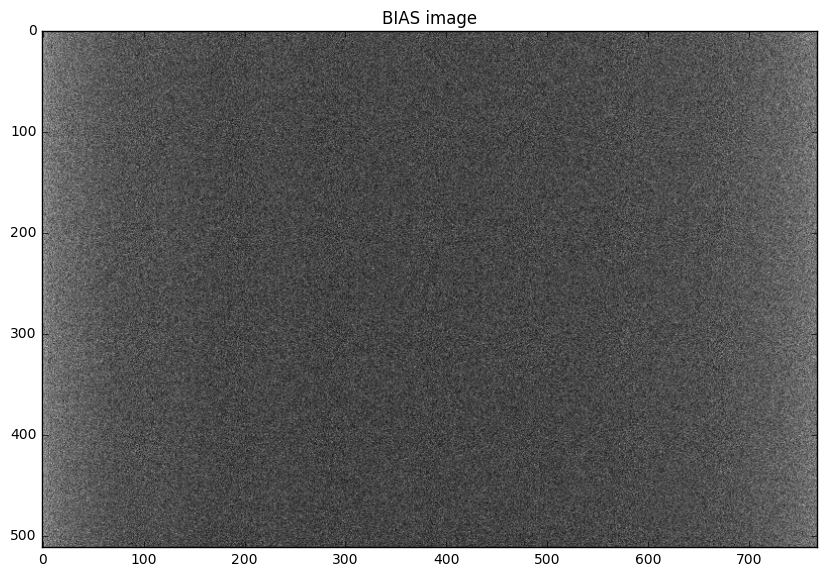

In [8]:
display_image(bias, downsample=4, title='BIAS image')

# Load the rest of the images

In [9]:
dark_one = CCDData.read(join(image_folder, 'dark_frame_one_median.fits'), unit='adu')
dark_two = CCDData.read(join(image_folder, 'dark_frame_two_median.fits'), unit='adu')
flat_R = CCDData.read(join(image_folder, 'flat_master_R.fits'), unit='adu')
ey_uma = CCDData.read(join(image_folder, 'ey-uma-060R.fit'), unit='adu')

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [ccdproc.ccddata]


# Image arithmetic

Simple arithmetic operations, like addition, subtraction and division, are carried out by operating on the *data* prat of the image. The cell below subtracts the bias from the dark image `dark_frame_one_median.fits`:

In [10]:
dark_sub_bias = dark_one.data - bias.data

### One important note about the result

The result is only data; it has no header.

Finally, this displays the subtracted data.

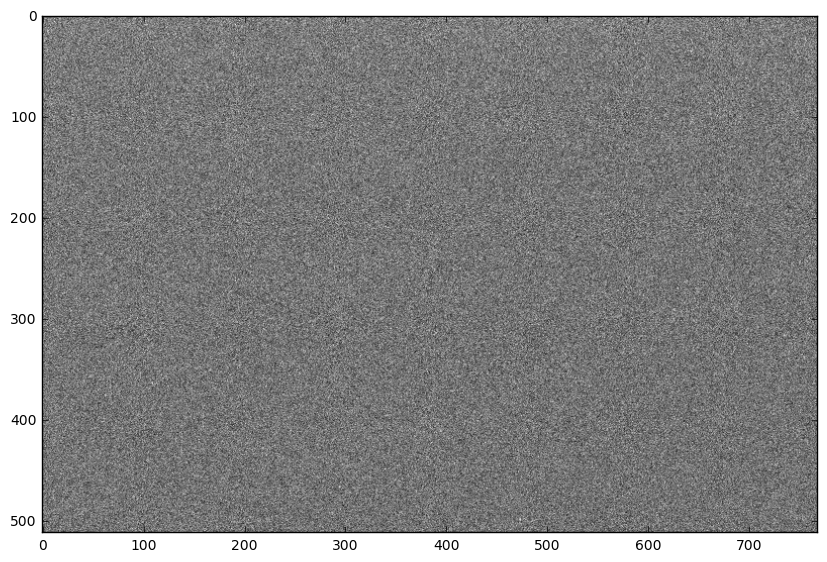

In [21]:
display_image(dark_sub_bias, downsample=4)

# Case 1

In the cell below, calculate the reduced image in the case when the dark exposure time matches the image exposure

## Display the reduced image in the cell below

You need to modify the cell for it to work.

In [ ]:
display_image()

# Case 2

In the cell below, calculate the reduced image in the case when the dark exposure time does **not** the image exposure.

## Display the reduced image in the cell below

You need to modify the cell for it to work.

In [ ]:
display_image()